In [1]:
import cv2
import numpy as np

# load image
#img = cv2.imread("Final_dataset/open1/train/image_0.jpg")

def dec_bbox(bbox, scale_factor):
    x, y, w, h = bbox
    delta_w = int((1-scale_factor) * w / 2)
    delta_h = int((1-scale_factor) * h / 2)
    return x + delta_w, y + delta_h, w - 2 * delta_w, h - 2 * delta_h

def preprocess_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([70, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    green_only = cv2.bitwise_and(image, image, mask=mask)
    gray = cv2.cvtColor(green_only, cv2.COLOR_BGR2GRAY)
    return gray

def get_green_window(img):
    threshold=preprocess_image(img)
    contours = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)
    
    x,y,w,h = dec_bbox(cv2.boundingRect(big_contour),0.9)
   # print(x,y,w,h)
    
    crop = img[y:y+h, x:x+w]
    return crop


#cv2.imwrite("screen_threshold.jpg", threshold)
#cv2.imwrite("screen_cropped.jpg", crop)

#cv2.imshow("threshold", threshold)
#cv2.imshow("crop", crop)
#cv2.waitKey(0)


In [2]:
import cv2
import cropped_rectangle
import numpy as np
from skimage.feature import hog

def normalize_hog_cell(hog_cell):
    hog_cell_norm = np.linalg.norm(hog_cell)
    normalized_hog_cell = hog_cell / (hog_cell_norm + 1e-5)  

    return normalized_hog_cell


def visualize_hog(hog_features, cell_size=(8, 8), orientations=9):
    num_cells_x = hog_features.shape[0]
    num_cells_y = hog_features.shape[1]

    pixels_per_cell_x = cell_size[0]
    pixels_per_cell_y = cell_size[1]

    image_height = num_cells_y * pixels_per_cell_y
    image_width = num_cells_x * pixels_per_cell_x

    hog_image = np.zeros((image_height, image_width))

    cell_center_x = pixels_per_cell_x // 2
    cell_center_y = pixels_per_cell_y // 2

    for y in range(num_cells_y):
        for x in range(num_cells_x):
            hog_cell =hog_features[x, y, :]
            center_x = x * pixels_per_cell_x + cell_center_x
            center_y = y * pixels_per_cell_y + cell_center_y
            
            total_magnitude = np.sum(hog_cell)
            
            if total_magnitude > 0:
                hog_cell /= total_magnitude

            for i in range(orientations):
               # i= np.argmax(hog_cell)
                angle = i * (180 / orientations)
                
                dx = np.cos(np.radians(angle)) * hog_cell[i]
                dy = np.sin(np.radians(angle)) * hog_cell[i]
                x1 = int(center_x - dx * cell_size[0] / 2)
                y1 = int(center_y - dy * cell_size[1] / 2)
                x2 = int(center_x + dx * cell_size[0] / 2)
                y2 = int(center_y + dy * cell_size[1] / 2)
                
                cv2.line(hog_image, (x1, y1), (x2, y2), color=int(255**hog_cell[i]), thickness=1)
    

    return hog_image

def compute_gradients(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    angle = np.arctan2(sobel_y, sobel_x) * (180 / np.pi)
    angle[angle < 0] += 180 
    
    return magnitude, angle

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 128))
    return resized


def calc_hog(magnitude,angle,cell_size,num_bins=9):
    cell_wid=magnitude.shape[1] // cell_size
    cell_height=magnitude.shape[0] // cell_size
    cell_hist = np.zeros((cell_wid, cell_height, num_bins))
    
    cell_vec = np.zeros((cell_wid-1, cell_height-1, 36))
    
    for i in range(0,cell_wid):
        for j in range(0,cell_height):
            angle_cell=angle[j*cell_size:(j+1)*cell_size,i*cell_size:(i+1)*cell_size]
            magnitude_cell=magnitude[j*cell_size:(j+1)*cell_size,i*cell_size:(i+1)*cell_size]
            cell_hist[i,j],_= np.histogram(angle_cell, bins=num_bins, range=(0, 180), weights=magnitude_cell)
            
        
    for i in range(cell_wid-1):
        for j in range(cell_height-1):
            cell_vec[i, j] = normalize_hog_cell(np.concatenate((cell_hist[i, j], cell_hist[i+1, j], cell_hist[i, j+1], cell_hist[i+1, j+1])))
    
    return cell_hist  , cell_vec.flatten(order='C') 
                
            
    
#image = cv2.imread('Final_dataset/open1/train/image_1.jpg')


#test_image=preprocess_image(test_image)

def calc_img_hog1(image):

    cropped_img=cropped_rectangle.get_green_window(image)
    gray_img=preprocess_image(cropped_img)
    grad_mag,grad_angle=compute_gradients(gray_img)


    hog_features,block_features = calc_hog(grad_mag, grad_angle, cell_size=8)

    return block_features


def calc_img_hog2(image):

    #cropped_img=cropped_rectangle.get_green_window(image)
    gray_img=preprocess_image(image)
    grad_mag,grad_angle=compute_gradients(gray_img)

    hog_features,block_features = calc_hog(grad_mag, grad_angle, cell_size=8)

    return block_features

#hog_image = visualize_hog(hog_features)
#fd, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True)

# Display the HOG image
#hog_image = cv2.resize(hog_image, (64 * 4, 128 * 4))
#cv2.imshow('HOG Image', hog_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#cv2.imshow('Detected Hands', gray_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [6]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.6 MB 656.4 kB/s eta 0:00:17
    --------------------------------------- 0.2/10.6 MB 1.6 MB/s eta 0:00:07
   - -------------------------------------- 0.5/10.6 MB 3.0 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/10.6 MB 4.9 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/10.6 MB 4.7 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/10.6 MB 6.9 MB/s eta 0:00:02
   ----------- ---------------------------- 3.2/10.6 MB 8.8 MB/s eta 0:00:01
   ---------------- ----------------------- 4.3/10.6 MB 10.6 MB/s eta 0:00:01
   --------------------- ------------------ 5.7/10.6 MB 13.1 MB/s eta 0:00:01
   -------------------

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import os
import cv2
import hog

def extract_hog_features_from_folder1(folder_path, label):
    hog_features_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            hog_features = hog.calc_img_hog1(image)
            hog_features_list.append(hog_features)
    return hog_features_list


def extract_hog_features_from_folder2(folder_path, label):
    hog_features_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            hog_features = hog.calc_img_hog2(image)
            hog_features_list.append(hog_features)
    return hog_features_list

hands_features = extract_hog_features_from_folder1('Final_dataset/Hands', label=1)
print("D1***************************")
non_hands_features = extract_hog_features_from_folder2('Final_dataset/NonHands', label=0)
print("D2***************************")

X = hands_features + non_hands_features
y = [1] * len(hands_features) + [0] * len(non_hands_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC()
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)


D1***************************
D2***************************
Accuracy: 1.0


In [14]:
im_path = os.path.join('Final_dataset/closed1/train', 'image_108.jpg')
im = cv2.imread(im_path)
im = hog.calc_img_hog1(im)
x=clf.predict(im.reshape(1,-1))
print(x)

[1]


ValueError: X has 2 features, but SVC is expecting 3780 features as input.

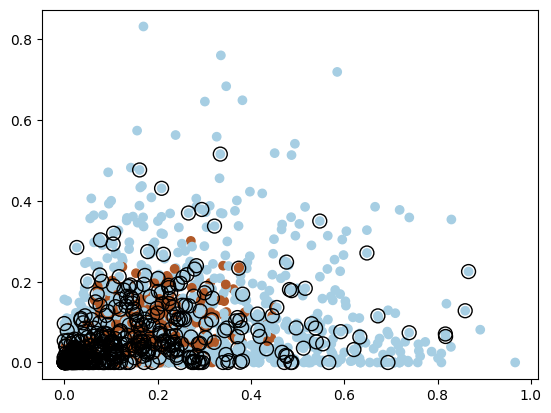

In [17]:
import matplotlib.pyplot as plt
def visualize_svm(clf, X, y):
    # Plotting the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', label='Data Points')

    # Getting support vectors
    support_vectors = clf.support_vectors_
    support_indices = clf.support_

    # Plotting support vectors
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')

    # Plotting decision boundary
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Decision Boundary with Support Vectors')
    plt.legend()
    plt.show()
visualize_svm(clf, np.array(X_train), np.array(y_train))
